ISSUE of NEURAL NETWORK: Extreme Values of propensity score predicted by NN

Solution: Penalize the extremes more

Define new loss function 1: mean square error

Define new loss function 2: 
$$
F(W,X) = (\theta_0(1-W)+\theta_1(W))*X
$$
ST. $|(\theta_0 \theta_1)| \le B$

Define new loss function 3: Min Max linear estimation

Define new loss function 4: NTK

In [ ]:
def minimax_loss(y_true, y_pred, sigma2=1.0, n=3651, Theta=None):
    
    MSE = tf.square(y_true - y_pred) 
    
    I2M = tf.reduce_max(MSE)
    
    L2norm2 = tf.add_n([tf.reduce_sum(tf.square(theta)) for theta in Theta]) / n
  
    gamma = I2M + (sigma2 / n) * L2norm2

    return gamma

# Using a basic CNN model 
def cnn_model_mmloss(variance = 1.0, n_samples = 3651):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    opt = keras.optimizers.Adam(learning_rate=1e-3)

    Theta = model.trainable_weights
    
    # Compile the model with custom loss
    minimax_loss_fn = lambda y_true, y_pred: minimax_loss(y_true, y_pred, variance, n_samples, Theta),
    
    model.compile(
        optimizer=opt,
        loss=minimax_loss_fn,
        metrics=['accuracy']
    )
    
    return model

model, history = train_model(
    image_arrays=df_combined['image_array'].values,
    model = cnn_model_mmloss(),
    labels=W,
    epochs=10,
    batch_size=64
)

P_hat = predict_p(model, df_combined['image_array'].values)

def cnn_model_regular():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), kernel_regularizer=l2(2.739e-4)),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(2.739e-4)),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=l2(2.739e-4)),

        Dense(1, activation='sigmoid')
    ])

    opt = keras.optimizers.Adam(learning_rate=1e-4)

    model.compile(
        optimizer=opt,
        loss='mean_squared_error',
        metrics=['accuracy']
    )

    return model

model, history = train_model(
    image_arrays=df_combined['image_array'].values,
    model = cnn_model_regular(),
    labels=W,
    epochs=10,
    batch_size=64
)

P_hat = predict_p(model, df_combined['image_array'].values)

P_hat = predict_p(model, df_combined['image_array'].values)

P_hat = np.clip(P_hat, 0.1, 0.9)

ipw_terms = [(w*y1/p-(1-w)*y0/(1-p)) for p, w, y1,y0 in zip(P_hat,W,Y1,Y0)]
ipw_estimate = np.mean(ipw_terms)
print(ipw_estimate)

In [ ]:
def f(W, X, theta_0, theta_1):
    return theta_0 * (1-W) + theta_1 * W * X

def max_object(gamma, W, X, theta_0, theta_1):
    f_max = np.mean(gamma * f(W, X, theta_0, theta_1)) - np.mean(f(1, X, theta_0, theta_1) - f(0, X, theta_0, theta_1))
    return f_max

def min_object(m_0, m_1, m_2, X):
    return m_0 + m_1*X + m_2*X**2

def maximize_f(params, gamma, W, X):
    theta_0, theta_1 = params[0], params[1]
    return -(max_object(gamma, W, X, theta_0, theta_1))**2 
#+ np.mean(gamma**2)

theta_constraint = {'type': 'ineq', 'fun': lambda theta: 1 - np.linalg.norm(theta)}
m_constraint = {'type': 'ineq', 'fun': lambda m: 1 - np.linalg.norm(m)}

result_max = minimize(
    max_object,
    [theta_0, theta_1],
    args=(gamma_1, W, X),
    constraints= [theta_constraint],
    method='L-BFGS-B'
)

theta_0, theta_1 = result_max.x[0], result_max.x[1]

result_min = minimize(
    min_object,
    [m_0, m_1, m_2],
    args=(X),
    constraints= m_constraint,
    method='L-BFGS-B',
)
gamma_optim = result_min.x  
min = result_min.fun

def max_objective(B, psi, gamma, W):
    f = np.dot(psi, B)
    obj_value = np.mean(gamma * f) - np.mean(f[W == 1]) + np.mean(f[W == 0])
    return -obj_value

#B_constraint = {'type': 'ineq', 'fun': lambda B: 1 - np.linalg.norm(B)}

result_max = minimize(
    max_objective,
    B,
    args=(psi, gamma_1, W),
    #constraints=[B_constraint],
    method='SLSQP'
)

B_optimal = result_max.x



### Estimate Propensity Score using NN

### (3) Neural Network Treatment Assignment

In [ ]:
df_combined['label_bacteria'] = np.where(df_combined['label'] == 'BACTERIA', 'Y', 'N')
train_df, val_df = train_test_split(df_combined, test_size=0.2, random_state=42)

# ImageDataGenerator for augmenting and preprocessing images
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create generators to load data in batches
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_name',  # Column with file paths
    y_col='label_bacteria',  # Column with labels
    target_size=(224, 224),  # ResNet50 input size
    class_mode='binary',  # Binary classification
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='file_name',  # Column with file paths
    y_col='label_bacteria',  # Column with labels
    target_size=(224, 224),  # ResNet50 input size
    class_mode='binary',  # Binary classification
    batch_size=32,
    shuffle=False
)

# Load the pretrained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the ResNet base
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(1, activation='sigmoid')(x)  # Binary output (Bacteria or not)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

steps_per_epoch = len(train_df) // 32  # Assuming a batch size of 32
validation_steps = len(val_df) // 32

# Train the model using the generators
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.


/Users/wangzijian/Desktop/HONOR/python_honor/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
130/130 ━━━━━━━━━━━━━━━━━━━━ 70s 499ms/step - accuracy: 0.7686 - loss: 0.7407 - val_accuracy: 0.7295 - val_loss: 0.5780
Epoch 2/3
  1/130 ━━━━━━━━━━━━━━━━━━━━ 52s 404ms/step - accuracy: 0.7812 - loss: 0.4075

2024-10-21 23:59:03.571728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_26]]
2024-10-21 23:59:03.571763: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12071580376226191310
2024-10-21 23:59:03.571768: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4691095104562247994
2024-10-21 23:59:03.571771: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15966872574696317270
2024-10-21 23:59:03.571775: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8359750986700190526
2024-10-21 23:59:03.571778: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3769135535625455250
2024-10-21 23:59:03.571832: I

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7812 - loss: 0.4075 - val_accuracy: 0.7000 - val_loss: 0.5855
Epoch 3/3


2024-10-21 23:59:04.886116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 23:59:04.886160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-21 23:59:04.886177: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1607332398738260649
2024-10-21 23:59:04.886187: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13846743133607441245
2024-10-21 23:59:04.886198: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13967589491194578303


130/130 ━━━━━━━━━━━━━━━━━━━━ 60s 463ms/step - accuracy: 0.8079 - loss: 0.4109 - val_accuracy: 0.8066 - val_loss: 0.4490


In [ ]:


def NN_treat_prob(img_path, model):
    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Make prediction
    predictions = model.predict(img_array)
    
    # Return the probability for the Bacteria class
    return predictions[0][0]

def assign_by_NN(file_names, labels, model):
    y_unchange = 0
    y_worse = -1
    y_better = 1
    y_worsen = -2

    p = []
    w = []
    y1 = []
    y0 = []

    for file_name, label in (zip(file_names, labels)):
        p_i = NN_treat_prob(file_name, model)
        w_i = np.random.binomial(1, p_i)

        if label == 'NORMAL':
            y_1 = y_unchange + p_i
            y_0 = y_unchange + p_i
        elif label == 'BACTERIA':
            y_1 = y_better + p_i
            y_0 = y_worse + p_i
        else:
            y_1 = y_worsen + p_i
            y_0 = y_worse + p_i

        p.append(p_i)
        w.append(w_i)
        y1.append(y_1)
        y0.append(y_0)

    return np.array(p), np.array(w), np.array(y1), np.array(y0)

# Assuming df_combined['file_name'] contains the full file paths and df_combined['label'] contains the labels


In [ ]:

P, W, Y1, Y0 = assign_by_NN(df_combined['file_name'], df_combined['label'], model=model)

P = np.array(P)
W = np.array(W)
Y1 = np.array(Y1)
Y0 = np.array(Y0)

ipw_terms = [(w*y1/p-(1-w)*y0/(1-p)) for w, p, y1, y0 in zip(W, P, Y1, Y0)]
ipw_estimate = np.mean(ipw_terms)
print(ipw_estimate)
# 5mins

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

In [ ]:
print(ipw_estimate)

0.7525080321263116


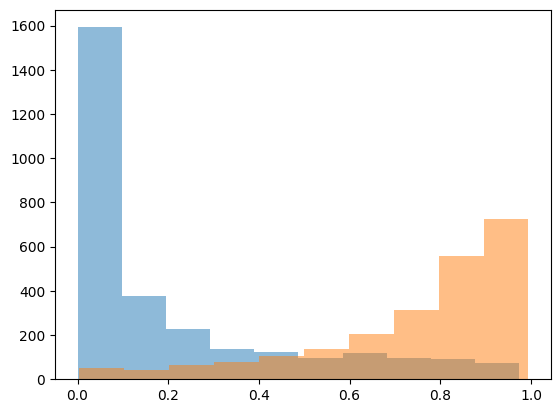

In [ ]:
plt.hist(P[W==0], alpha = 0.5)
plt.hist(P[W==1], alpha = 0.5)
plt.show()

In [ ]:
# Difference in Means
np.mean(Y1[W==1])-np.mean(Y0[W==0])

1.5036566917578158

In [ ]:
# True Parameter
np.mean(Y1-Y0)

0.7122315950920245

In [ ]:
# Using ResNet, MobileNet (pretrained model weights)
def cnn_model(input_shape=(224, 224, 1), variance=1.0, n_samples=3651):
    # Create base ResNet model
    base_model = ResNet101V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    # Create the model
    model = Sequential([
        # Input processing layers
        Conv2D(16, (3, 3), padding='same', use_bias=False, activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        
        # Convert to 3 channels for ResNet
        Conv2D(32, (3, 3), padding='same', activation='relu', use_bias=False),
        MaxPooling2D(2, 2),
        
        Conv2D(3, (3, 3), padding='same', activation='relu', use_bias=False),
        
        # Lambda layer to ensure proper shape for ResNet
        #tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (224, 224))),
        tf.keras.layers.Resizing(224, 224),
        # Insert pre-trained ResNet
        base_model,
        
        GlobalAveragePooling2D(), # overfitting

        Dense(64, activation='relu'),
        Dropout(0.2),
        
        Dense(1, activation='sigmoid')  # For binary classification
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# Using a basic CNN model 
def cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        
        Dense(1, activation='sigmoid')
    ])

    opt = keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:


def prepare_data(image_arrays, labels):
    # 4D array (samples, height, width, channels)
    X = np.stack(image_arrays)
    y = np.array(labels)

    return X, y

# Training function
def train_model(image_arrays, model, labels, epochs, batch_size=64):

    X, y = prepare_data(image_arrays, labels)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, train_size=0.7, random_state=123
    )
    
    model = model
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    
    return model, history

def predict_p(model, image_arrays):
    # Prepare images
    X, y = prepare_data(image_arrays, np.zeros(len(image_arrays)))
    
    return model.predict(X, verbose=0).flatten()



In [ ]:
model, history = train_model(
    image_arrays=df_combined['image_array'].values,
    model = cnn_model(),
    labels=W,
    epochs=10,
    batch_size=64
)

P_hat = predict_p(model, df_combined['image_array'].values)

/Users/wangzijian/Desktop/HONOR/python_honor/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-27 20:45:00.353176: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-27 20:45:00.353366: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-10-27 20:45:00.353382: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-10-27 20:45:00.353534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-27 20:45:00.353551: I tensorflow/core/common_runtime/pluggable_device/plu

Epoch 1/10


2024-10-27 20:45:02.128347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step - accuracy: 0.5058 - loss: 2.2893 - val_accuracy: 0.5610 - val_loss: 0.6610
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 18s 308ms/step - accuracy: 0.5877 - loss: 0.6530 - val_accuracy: 0.6300 - val_loss: 0.6241
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 18s 303ms/step - accuracy: 0.6312 - loss: 0.6318 - val_accuracy: 0.6562 - val_loss: 0.6107
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 18s 306ms/step - accuracy: 0.6408 - loss: 0.6384 - val_accuracy: 0.6754 - val_loss: 0.5916
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 337ms/step - accuracy: 0.6445 - loss: 0.6216 - val_accuracy: 0.6824 - val_loss: 0.5826
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 333ms/step - accuracy: 0.6925 - loss: 0.5969 - val_accuracy: 0.6952 - val_loss: 0.5801
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 334ms/step - accuracy: 0.6542 - loss: 0.6130 - val_accuracy: 0.6978 - val_loss: 0.5776
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 324ms/step - accuracy: 0.6874 - loss: 0.5902 - val_accuracy: 0.728

In [ ]:
P_hat = predict_p(model, df_combined['image_array'].values)
print(np.max(P_hat))
print(np.min(P_hat))

0.9490959
0.0072552147


In [ ]:
P_hat = np.clip(P_hat, 0.01, 0.99)

ipw_terms = [(w*y1/p-(1-w)*y0/(1-p)) for p, w, y1,y0 in zip(P_hat,W,Y1,Y0)]
ipw_estimate = np.mean(ipw_terms)
print(ipw_estimate)

1.3970347706167388


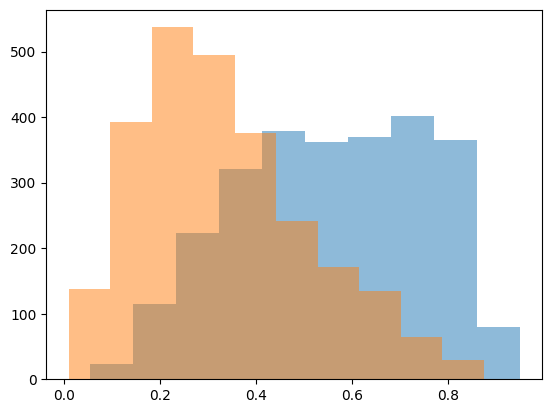

In [ ]:
plt.hist(P_hat[W==1], alpha = 0.5)
plt.hist(P_hat[W==0], alpha = 0.5)
plt.show()

$$
min_\gamma[max_f(\sum_i{\gamma_i f(W_i, X_i)}-\sum_i{f(1,X_i)-f(0, X_i)})]
$$

$$
\gamma_i \approx \frac{W_i}{e(X_i)}-\frac{1-W_i}{1-e(X_i)}
$$

## KERNEL CODE 1 (RBF)

In [ ]:
from scipy.spatial.distance import cdist
c = 1
d = 2
s = 120
sw= 10
WX = np.stack([W*sw, X/s], axis = 1)
WX_0 = np.stack([np.zeros_like(X),X/s], axis = 1)
WX_1 = np.stack([np.ones_like(X)*10,X/s], axis = 1)

# K_XX = (np.outer(X,X)+c)**d
# K_WW = (np.outer(W,W)+c)**d
# K_XX *= K_WW


K_XX = np.exp(-cdist(WX, WX, 'sqeuclidean'))
K_X1 = np.exp(-cdist(WX, WX_1, 'sqeuclidean'))@ np.ones((n, 1))
K_X0 = np.exp(-cdist(WX, WX_0, 'sqeuclidean'))@ np.ones((n, 1))

K_Xdiff = K_X1 - K_X0


sigma_squared = 1e-6
n = len(X)
I = np.eye(K_XX.shape[0])

# Solve for gamma
gamma_optimal = (np.linalg.solve((1/n**2)*K_XX + (1/n**2)*sigma_squared * I, (2/n**2)*(-K_Xdiff))).flatten()

# gamma_optimal[W == 1]/= np.mean(W) 
# gamma_optimal[W == 0]/= np.mean(1-W)
print(np.mean(gamma_optimal[W==1]))
print(np.mean(gamma_optimal[W==0]))

K_XX[W==0, :][:, W==1]
K_XX[W==1, :][:, W==1]

x = np.array(range(0,220))
plt.scatter(X, gamma_optimal, c = W,alpha = .1)
plt.plot(x, 1/(propensity_score(x)/np.mean(W)), color = 'red')
plt.plot(x, 1/((propensity_score(x)-1)*np.mean(1-W)), color = 'blue')
plt.ylim(-10,10)

In [ ]:
from scipy.spatial.distance import cdist
import numpy as np

def ntk_kernel_with_masking(W, X_ntk, sw, s, sigma):
    """
    Constructs the NTK-based kernel matrix with masking based on treatment assignments W.
    """
    # Scale NTK features
    W_scaled = W * sw  # Scale treatment indicator
    X_ntk_scaled = X_ntk / s  # Normalize NTK features
    
    # # Stack W with NTK features
    # WX_ntk = np.column_stack([W_scaled, X_ntk_scaled])
    # WX_ntk_0 = np.column_stack([np.zeros_like(W), X_ntk_scaled])  # Control group (W=0)
    # WX_ntk_1 = np.column_stack([np.ones_like(W) * sw, X_ntk_scaled])  # Treatment group (W=1)

    K_NTK = np.exp(-cdist(X_ntk_scaled, X_ntk_scaled, 'sqeuclidean') / (2 * sigma**2))
    # K_NTK_X1 = np.exp(-cdist(K_NTK, WX_ntk_1, 'sqeuclidean') / (2 * sigma**2)) @ np.ones((len(K_NTK), 1))
    # K_NTK_X0 = np.exp(-cdist(K_NTK, WX_ntk_0, 'sqeuclidean') / (2 * sigma**2)) @ np.ones((len(K_NTK), 1))
    W_treated = W[:, None] == 1  # Column vector (n_samples, 1), True where W=1
    W_control = W[:, None] == 0 # Column vector (n_samples, 1), True where W=0
    # Compute kernel similarity between each sample and the **treatment** group
    K_NTK_X1 = K_NTK @ W_treated
    # Compute kernel similarity between each sample and the **control** group
    K_NTK_X0 = K_NTK @ W_control

    # Apply masking based on treatment assignments
    same_w_mask = (W[:, None] == W[None, :])
    K_NTK_masked = K_NTK * same_w_mask

    # Compute Kernel Difference
    K_NTK_diff = K_NTK_X1 - K_NTK_X0

    return K_NTK_masked, K_NTK_diff

# Constants for scaling
sw = 1  # Treatment weight scale
s = np.mean(X_ntk)  # Normalization factor
sigma2 = 0.25  # Kernel bandwidth

# Compute kernel matrices
K_NTK_masked, K_NTK_diff = ntk_kernel_with_masking(W, X_ntk, sw, s, sigma=sigma2)

print("Masked NTK Kernel K_XX (based on W):")
print(K_NTK_masked)


# Solve for optimal gamma
n = len(X_ntk)
I = np.eye(K_NTK_masked.shape[0])
sigma_squared = sigma2**2
lambda1 = 1e-8

gamma_optimal = (np.linalg.solve(K_NTK_masked + lambda1 * I, (K_NTK_diff))).flatten()

# Compute IPW Estimate
Y = W * Y1 + (1 - W) * Y0 
ipw_estimate = np.mean(gamma_optimal * Y)

print("Optimal gamma:", gamma_optimal)
print("IPW estimate:", ipw_estimate)

# def K_Xdiff(W, F0, F1):
#     idx_control = (W == 0)
#     idx_treated = (W == 1)
#     K_treated = F1 @ F1.T   # shape (n, n)
#     K_control = F0 @ F0.T  # shape (n, n)
#     diff= (np.sum(K_treated[:, idx_treated], axis=1) - np.sum(K_control[:, idx_control], axis=1))/n
#     return diff

# def K_Xdiff(W, F):
#     K_diff = np.zeros(5216)
#     for i in range(5216):
#         if W[i] == 1:
#             K_diff[i] = np.sum(F[i] * F)
#         else:
#             K_diff[i] = -np.sum(F[i] * F)
#     return K_diff

In [ ]:
## NTK

# F = []
# for i in range(5216):
#     if W[i] == 0:
#         grad_c = grad(X_full[i:(i+1)], model_control)
#         F.append(grad_c)
#     else:
#         grad_t = grad(X_full[i:(i+1)], model_treated)
#         F.append(grad_t)

# F = np.array(F)
# print(F.shape)

def polynomial_kernel(X,Y, c, d):
    dot_product = X @ Y.T  
    K = (dot_product + c) ** d 
    
    return K

def rbf_kernel(X,Y, sigma):
    dist2 = cdist(X, Y, 'sqeuclidean')
    K = np.exp(-dist2/(2.0*sigma**2))
    
    return K

def K_mat(W, F):
    K_XX = np.zeros((5216, 5216))
    for i in range(5216):
        for j in range(5216):
            if W[i] == W[j]:
                K_XX[i,j] = polynomial_kernel(F[i], F[j], c=1, d=3)
            else:
                K_XX[i,j] = 0

    return K_XX


# def K_Xdiff(W, F):
#     n = len(W)
#     K_diff = np.zeros(n)
#     for i in range(n):
#         treated_sum = np.sum([polynomial_kernel(F[i],F[j], c=1, d=2) for j in range(n) if W[j] == 1])
#         control_sum = np.sum([polynomial_kernel(F[i], F[j], c=1, d=2) for j in range(n) if W[j] == 0])
        
#         K_diff[i] = treated_sum - control_sum  # Instead of separate summation
    
#     return K_diff

def K_Xdiff(W, K_XX):
    n = len(W)
    treated_idx = np.where(W == 1)[0]
    control_idx = np.where(W == 0)[0]
    
    K_diff = np.sum(K_XX[:, treated_idx], axis=1) - np.sum(K_XX[:, control_idx], axis=1)
    
    return K_diff

K_XX = K_mat(W, F)

K_diff = K_Xdiff(W, K_XX)
print(K_diff)
print(K_XX)

# Solve for optimal gamma
n = 5216
I = np.eye(K_XX.shape[0])
#sigma_squared = sigma2**2
lambda1 = 10

#gamma_optimal = (np.linalg.solve(K_XX + lambda1 * I, (K_diff))).flatten()
gamma_optimal = (np.linalg.solve(K_XX + lambda1 * I, K_diff)).flatten()

# Compute IPW Estimate
Y = W * Y1 + (1 - W) * Y0 
ipw_estimate = np.mean(gamma_optimal * Y)

print("Optimal gamma:", gamma_optimal)
print("IPW estimate:", ipw_estimate)

X = brightness_f(bright_matrix)
x = np.array(range(0,220))
plt.scatter(X, gamma_optimal, c = W,alpha = .5, s = 1)
plt.plot(x, 1/(propensity_score(x)/np.mean(W)), color = 'red')
plt.plot(x, 1/((propensity_score(x)-1)*np.mean(1-W)), color = 'blue')
plt.ylim(-10,10)